# EECE568 - Assignment 3

### Mount on Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/ColabNotebooks/EECE_568/Assignment_3/

/content/gdrive/MyDrive/ColabNotebooks/EECE_568/Assignment_3


### Imports

In [3]:
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
print("Running on torch.__version__ = ", torch.__version__)

torch.backends.cudnn.deterministic = True

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

Running on torch.__version__ =  2.1.0+cu121


### Helper Functions

In [4]:
# a function to move tensors from the CPU to the GPU and vice versa
def dict_to_device(orig, device):
    new = {}
    for k, v in orig.items():
        if isinstance(v, torch.Tensor):
            new[k] = v.to(device)
        elif isinstance(v, list):
            new[k] = [item.to(device) for item in v if isinstance(item, torch.Tensor)]
        else:
            new[k] = v  # If it's neither a tensor nor a list of tensors, leave it unchanged
    return new

# a function to plot a batch of images together
def plot_images(img, ax):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

# a function to make a tuples
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# a function to plot the attention weights' heatmap
def plot_attention_heatmap(attention, tokens):
    '''
    attention: tensor or numpy array of shape (n_tokens, n_tokens)
    tokens: tensor or numpy array of shape (n_tokens)
    '''
    tokens = tokens.detach().cpu().numpy() if torch.is_tensor(tokens) else tokens
    attention = attention.detach().cpu().numpy() if torch.is_tensor(attention) else attention

    assert len(tokens) == 20, 'Please plot the attentions between the first 20 tokens.'
    assert attention.shape == (len(tokens), len(tokens)), 'attention.shape shoud be (len(tokens), len(tokens))'

    token_names = [token2word[token.item()] for token in tokens]

    # Plot the attention weights for the first example in the batch and the first head in the last layer
    fig, ax = plt.subplots(figsize=(len(tokens) + 2, len(tokens) + 2))
    im = ax.imshow(attention, cmap='magma', interpolation='nearest')

    # Add the token names to the x-axis
    ax.set_xticks(np.arange(len(token_names)))
    ax.set_xticklabels(token_names)
    ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

    # Add the token names to the y-axis
    ax.set_yticks(np.arange(len(token_names)))
    ax.set_yticklabels(token_names)

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()

# a function for visualizing high-dimensional data by mapping it to a 2D space
def plot_tsne(word_embeddings):
    embeddings = word_embeddings.weight.data[1000:3000, :]
    embeddings = embeddings.cpu().numpy() if torch.is_tensor(embeddings) else embeddings
    embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, verbose=1, random_state=0)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Plot the t-SNE embeddings with labels
    n_tokens = 32
    tokens = random.choices(list(range(embeddings.shape[0])), k=n_tokens)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(tsne_embeddings[tokens, 0], tsne_embeddings[tokens, 1])
    for i in range(n_tokens):
        word = token2word[tokens[i]]
        ax.annotate(word, (tsne_embeddings[tokens[i], 0], tsne_embeddings[tokens[i], 1]))
    plt.show()

## Q1 (10 pts)

### Load and Tokenize Data

In [5]:
data = pd.read_csv('./imdb_processed.csv')
data.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [6]:
# obtain list of words
words = ' '.join(data.processed.values).split()

# check our list
words[30:40]

[',',
 'show',
 'faint',
 'hearted',
 'timid',
 '.',
 'This',
 'show',
 'pull',
 'punch']

In [7]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
token2word = dict(enumerate(vocab, 1))
token2word[0] = '<PAD>'
word2token = {word: id for id, word in token2word.items()}

print("vocab size:", len(word2token))

vocab size: 121301


In [8]:
# tokenize reviews
reviews = data.processed.values
reviews_tokenized = [[word2token[word] for word in review.split()] for review in tqdm(reviews)]

# padding sequences
def pad_features(reviews, pad_id, seq_length):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)
    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

features = pad_features(reviews_tokenized, pad_id=word2token['<PAD>'], seq_length=256)

print('number of reviews:', len(reviews_tokenized))
print('seq_length:', len(features[0]))

# print first-5 words of first 3 reviews
print('\n first-five words of the first-three reviews:')
print('===============')
features[:3, :5]

100%|██████████| 50000/50000 [00:01<00:00, 29612.33it/s]


number of reviews: 50000
seq_length: 256

 first-five words of the first-three reviews:


array([[ 191, 1083,  930,   81, 3724],
       [  47,  328,   59,  244,    1],
       [   3,   95,  328,   30, 1041]])

### Dataloader

In [9]:
# we use 70%, 15%, 15% for train, validation, and test sets
train_size = .7
val_size = .5
labels = data.label.to_numpy()

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, reviews, labels):
        self.data = torch.utils.data.TensorDataset(torch.from_numpy(reviews), torch.from_numpy(labels).float())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = self.data[index][0]
        label = self.data[index][1]

        return {'review': review, 'label': label}


train_set = MyDataset(train_x, train_y)
val_set = MyDataset(val_x, val_y)
test_set = MyDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=128)

### ToDo: Network (5 pts)

Implement a **Transformer** classifier that takes a series of words (a review) as input and returns the label of the review indicating whether it is positive (1) or negative (0).

Your network should take a python dictionary as input and extract the input sentences from it. Your network should return a python dictionaly containing the
predicted label ('label') and the self-attention weights ('attention') from the last encoder layer in your transformer.

In [11]:
# ToDo: Implement your network

import math
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()

        # ToDo: code here

        # Define attributes
        self.vocab_size = len(word2token)       # Vocabulary size
        self.embedding_dim = 256            # Dimension of embedding layer
        self.max_seq_length = 256           # Maximum sequence length
        self.head_count = 8              # Number of heads in multi-head attention
        self.feedforward_dim = 256           # The dimension of feedforward network
        self.layer_count = 1              # Number of transformer layers

        # Add embedding layer to convert word tokens into vector embeddings
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        # Add positional encodings
        self.pos_encodings = PositionalEncoding(self.embedding_dim, self.max_seq_length, dropout=0.1)

        # Add transformer encoder
        self.encoder = CustomTransformerEncoder(
            emb_size = self.embedding_dim,
            nhead = self.head_count,
            nhid = self.feedforward_dim,
            nlayers = self.layer_count,
            dropout = 0.1
        )

        # MLP head for class prediction (binary classification)
        self.fc = nn.Linear(self.embedding_dim, 2)


        # Initialization
        self.init_weights()


    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()


        # - start with an embedding layer to convert word tokens into vector embeddings
        # - add positional encodings to word emebeddings
        # - using dropout might be helpful
        # - use a transformer encoder to calculate the attention weights
        # - apply an mlp head on top of the transformer to predict the label


    def forward(self, input_dict):
        x = input_dict['review']

        # ToDo: code here

        # Check if input is long tensor
        if x.dtype is not torch.long:
            x = x.long()

        # Embedding and positional encoding
        x = self.embedding(x) * math.sqrt(self.embedding_dim)
        x = self.pos_encodings(x)

        # Reshape x for transformer encoder
        x = x.permute(1, 0, 2)

        # Custom transformer encoder (with attention)
        x, attention = self.encoder(x)

        # Reshape back
        x = x.permute(1, 0, 2)

        # Average pooling and classification
        x = x.mean(dim=1)
        label = self.fc(x)

        return {'label': label, 'attention': attention}


# Positional encoding (dropout layer included)
class PositionalEncoding(nn.Module):
    def __init__(self, dimension, length, dropout):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(length).unsqueeze(1)
        division_term = torch.exp(torch.arange(0, dimension, 2) * -(math.log(10000.0) / dimension))
        pos_enc = torch.zeros(length, 1, dimension)
        pos_enc[:, 0, 0::2] = torch.sin(position * division_term)
        pos_enc[:, 0, 1::2] = torch.cos(position * division_term)
        self.register_buffer('pos_enc', pos_enc)

    def forward(self, x):
        x = x + self.pos_enc[:x.size(0)]
        return self.dropout(x)


# Transformer encoder (returen output & attention weights)
class CustomTransformerEncoder(nn.Module):
    def __init__(self, emb_size, nhead, nhid, nlayers, dropout):
        super(CustomTransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([CustomTransformerEncoderLayer(emb_size, nhead, nhid, dropout) for _ in range(nlayers)])
        self.norm = nn.LayerNorm(emb_size)

    def forward(self, src):
        output = src
        attention_weights = []
        for mod in self.layers:
            output, attention = mod(output)
            attention_weights.append(attention)
        output = self.norm(output)
        return output, attention_weights


# Transformer encoder layer
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, emb_size, nhead, nhid, dropout):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(emb_size, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(emb_size, nhid)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(nhid, emb_size)
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.norm1(src)
        output, attention = self.self_attn(src2, src2, src2)
        src = src + self.dropout1(output)
        src2 = self.norm2(src)
        output = src + self.dropout2(self.linear2(self.dropout(F.relu(self.linear1(src2)))))
        return output, attention


network = Transformer().to('cuda')

In [12]:
total_params = sum(p.numel() for p in network.parameters())
print(f'The model has {total_params:,} parameters.')

The model has 31,449,858 parameters.


### Training

In [13]:
# feel free to implement your own loss function or use the suggested one here.

def my_loss_function(predicted_index, target_index):
  loss = nn.CrossEntropyLoss()(predicted_index, target_index)

  return loss

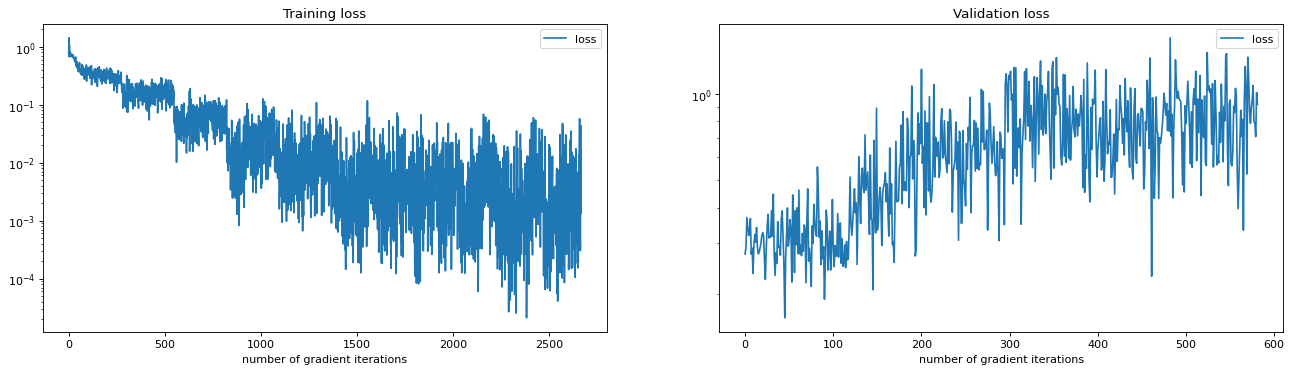

Validation epoch 9, iteration 50 of 59 (84 %), loss=0.91797


In [14]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss and backward the gradient
        loss = my_loss_function(pred['label'], batch_gpu['label'].long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()

            # plot the training error on a log plot
            axes[0].plot(train_losses, label='loss')
            axes[0].set_yscale('log')
            axes[0].set_title('Training loss')
            axes[0].set_xlabel('number of gradient iterations')
            axes[0].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={:0.5f}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))

    val_iter = iter(val_loader)
    network.eval()
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss
        with torch.no_grad():
            loss = my_loss_function(pred['label'], batch_gpu['label'].long())
            val_losses.append(loss.item())

        if i%10==0:
            axes[1].cla()

            # plot the validation error on a log plot
            axes[1].plot(val_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Validation loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={:0.5f}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))
plt.close('all')

### ToDo: Evaluation


#### Prediction Accuracy (1 pt)
The 'get_accuracy' function assumes that the network returns class probabilities as output. If your network returns class indices, you might need to change this evaluation function as well.

In [15]:
def get_accuracy(network, data_loader):
    network.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            batch_gpu = dict_to_device(batch, 'cuda')
            outputs = network(batch_gpu)['label']
            _, predicted = torch.max(outputs.data, 1)
            total += batch_gpu['label'].size(0)
            correct += (predicted == batch_gpu['label'].long()).sum().item()

    return correct / total

In [16]:
# ToDo: report accuracy on train, validation, and test sets
train_accuracy = get_accuracy(network, train_loader)
val_accuracy = get_accuracy(network, val_loader)
test_accuracy = get_accuracy(network, test_loader)

print(f"Accuracy on Train Set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Validation Set: {val_accuracy * 100:.2f}%")
print(f"Accuracy on Test Set: {test_accuracy * 100:.2f}%")

Accuracy on Train Set: 99.93%
Accuracy on Validation Set: 87.40%
Accuracy on Test Set: 86.81%


#### Attention Heatmap (2 pts)
Here, we want to visualize the self-attention weights using a heatmap. Visualize the attention between the first 20 tokens of a random review from the test-set. Use one of the attention heads from the last layer of your transformer encoder.

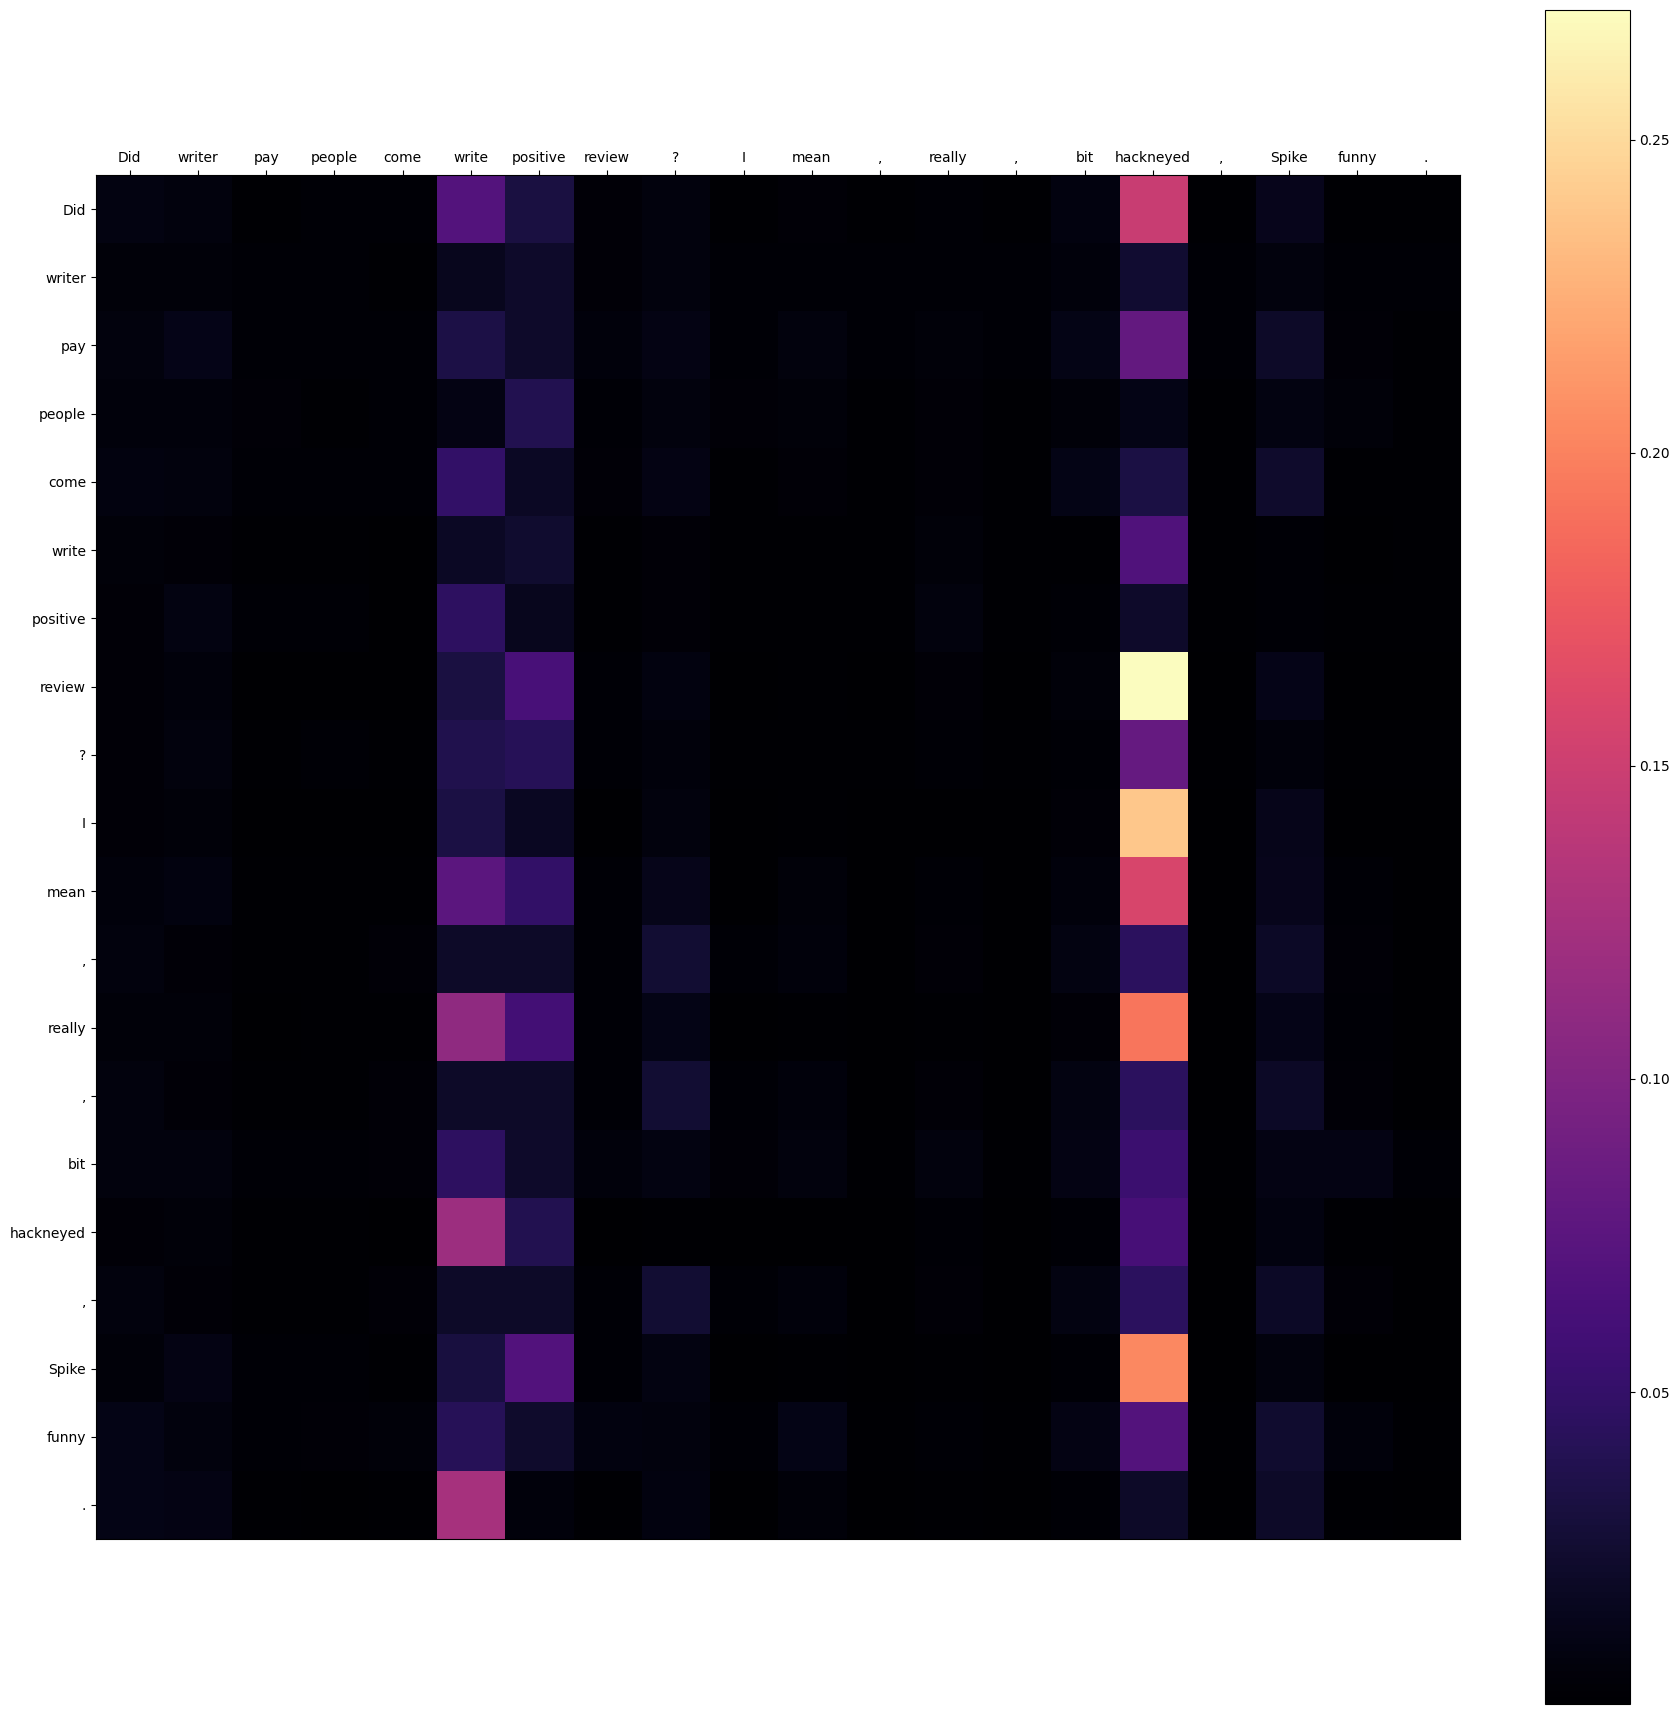

In [17]:
# ToDo: plot the heatmap of the self-attention weights
test_iter = iter(test_loader)
network.eval()
for i in range(len(test_loader)):
    batch_cpu = next(test_iter)
    batch_gpu = dict_to_device(batch_cpu, 'cuda')
    pred = network(batch_gpu)

    # ToDo: code here
    # Hint: use 'plot_attention_heatmap' in the Helper Functions section.


    # Extracting the attention weights and tokens
    attention = pred['attention']   # Could be a list of tensors or a tensor
    tokens = batch_cpu['review'][0]  # Select tokens of the first review in the batch

    # Ensure attention is a tensor and select the first head's attention
    if isinstance(attention, list):
        # Assume each item in the list is a tensor for each layer
        attention_weights = attention[0]      # Select weights from the first layer
    else:
        attention_weights = attention        # If it's already a tensor

    # Ensure it's a multi-head attention tensor with expected shape
    if len(attention_weights.shape) == 3:
        num_tokens = min(20, tokens.shape[0])   # Adjust number of tokens to actual length
        selected_attention = attention_weights[0, :num_tokens, :num_tokens]
    else:
        raise ValueError("Unexpected shape of attention weights")

    selected_tokens = tokens[:num_tokens]

    # Plotting the heatmap
    plot_attention_heatmap(selected_attention, selected_tokens)

    break

#### Word Embeddings (2 pts)
Here, we want to visualize the learned embeddings for our vocabulary words. To do that, we use t-SNE, which is a machine learning technique for visualizing high-dimensional data by mapping it to a low-dimensional space (usually 2D or 3D) while preserving the pairwise distances between points as much as possible.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.170s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.220711
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.256119
[t-SNE] KL divergence after 1000 iterations: 2.357519


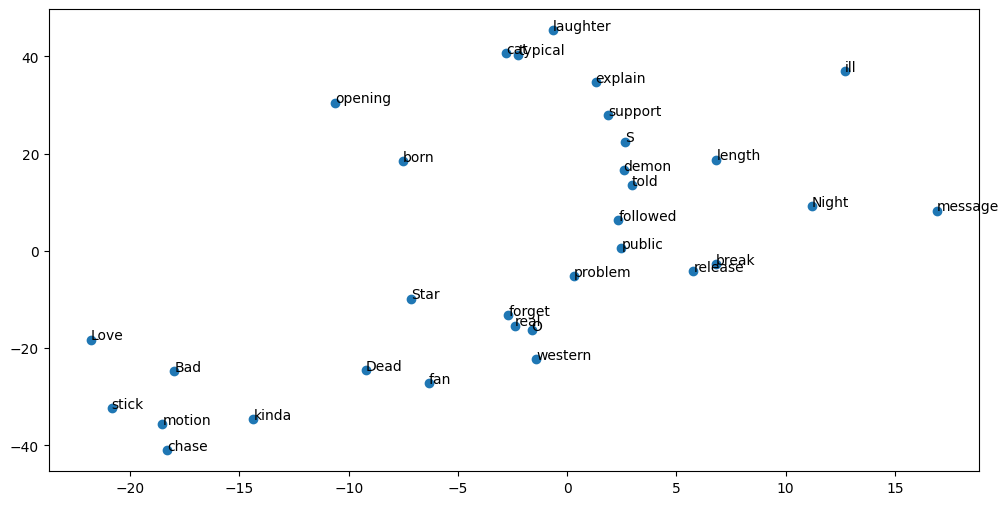

In [18]:
# ToDo: plot the learned word-embeddings in 2D

# ToDo: code here
# Hint: use 'plot_tsne' in the Helper Functions section. simply give the
#       word-embedding module of your network as input to 'plot_tsne' function

def visualize_embeddings(network):
    # Extracting the word embeddings from the model
    word_embeddings = network.embedding

    # Plotting the embeddings using t-SNE
    plot_tsne(word_embeddings)

# Visualize the embeddings
visualize_embeddings(network)

## Q2 (5 pts)

### Dataset and Dataloader

In [19]:
# Use standard MNIST dataset
class MyDataset(torchvision.datasets.MNIST):
    def __init__(self, *args, debug=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.debug = debug

    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        img = data[0]
        digit = data[1]
        return {'image': img, 'digit': digit}

    def __len__(self):
        return super().__len__()

dataset = MyDataset(
    root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]),
    debug=True,
)

test_set = MyDataset(
    root = './',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]),
    debug=True,
)

loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)

In [20]:
# Define the dataloaders and split into train, validation, and test

size = len(dataset)
train_set, val_set = torch.utils.data.random_split(dataset, [int(size * 0.8), int(size * 0.2)])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=0)

print('train_set:', len(train_set))
print('val_set:', len(val_set))
print('test_set:', len(test_set))

train_set: 48000
val_set: 12000
test_set: 10000


### ToDo: Network (3 pts)

Implement a **Vision Transformer** that takes an image as input and classifies it into ten classes, digits 0 to 9.

Your network should take a python dictionary as input and extract the input image from it. Your network should return a python dictionaly containing the
predicted class ('digit') of the input image.

In [21]:
# ToDo: Implement your network

import math

class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()

        # ToDo: code here

        # Define attributes
        self.image_size = 28                          # Size of each raw image per side (28 x 28)
        self.patch_size = 7                           # Size of each patch image per side (7 x 7)
        self.patch_count = (self.image_size // self.patch_size) ** 2    # Number of patches per side (4 * 4 = 16)
        self.embedding_dim = 256                        # Dimension of embedding layer
        self.head_count = 8                           # Number of heads
        self.feedforward_dim = 256                       # Dimension of the feedforward network model
        self.encoder_layer_count = 1                      # Number of sub-encoder-layers in the encoder

        # Add the patch embedding layer
        self.patch_embedding_layer = patch_embedding(1, self.patch_size, self.embedding_dim)

        # Initialize the class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, self.embedding_dim))

        # Add positional encodings (+1 for the class token) and dropout layer
        self.pos_encodings = nn.Parameter(self.get_pos_encodings(self.embedding_dim, self.patch_count+1), requires_grad=False)
        self.dropout_layer = nn.Dropout(0.1)

        # Add the transformer encoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer = nn.TransformerEncoderLayer(
                d_model = self.embedding_dim,
                nhead = self.head_count,
                dim_feedforward = self.feedforward_dim,
                dropout = 0.1
            ),
            num_layers = self.encoder_layer_count
        )

        # Add the MLP head for classification
        self.mlp_head = nn.Linear(self.embedding_dim, 10)

        # - start with a patch_embedding layer to divide image into patches and
        #   convert each patch into vector embeddings
        # - append a class token to image tokens
        # - add positional encodings
        # - using dropout might be helpful
        # - use a transformer encoder to calculate the attention weights
        # - apply an mlp head on the class token to predict the digit


    # Get positional encodings
    def get_pos_encodings(self, dimension, length):
        # Initialize a tensor of zeros for positional encodings with the specified length and dimension
        pos_enc = torch.zeros(length, dimension)

        # Generate a tensor of sequential positions and reshape it to (length, 1)
        # Calculate the division term used in the sin & cos functions
        position = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
        division_term = torch.exp(torch.arange(0, dimension, 2).float() * (-math.log(10000.0) / dimension))

        # Apply sin & cos functions to alternating positions
        # Sin function for even indices each row (0, 2, 4 ...)
        # Cos function for odd indices each row (1, 3, 5 ...)
        pos_enc[:, 0::2] = torch.sin(position * division_term)
        pos_enc[:, 1::2] = torch.cos(position * division_term)

        # Add an additional dimension at the beginning of the positional encoding tensor
        # Make it easier to add to the batch of embeddings later (1, length, dimension)
        pos_enc = pos_enc.unsqueeze(0)
        return pos_enc


    def forward(self, input_dict):
        x = input_dict['image']

        # ToDo: code here

        # Apply the patch embedding layer to the input image
        x = self.patch_embedding_layer(x)

        # Expand the class token for the entire batch (class token is a learnable parameter appended to the sequence of patch embeddings)
        class_tokens = self.class_token.expand(x.size(0), -1, -1)

        # Concatenate the class token with the patch embeddings (class token will be the first element)
        x = torch.cat((class_tokens, x), dim=1)

        # Add positional encodings to the patch embeddings (injects each patch's position information in the sequence)
        x = x + self.pos_encodings[:, :x.size(1)].repeat(x.size(0), 1, 1)

        # Pass the sequence through the transformer encoder
        x = self.encoder(x)

        # Aggregate the output of the transformer encoder (mean pooling for information across all patches)
        x = torch.mean(x, dim=1)

        # Pass to MLP head to produce the final classification prediction (output)
        digit_pred = self.mlp_head(x)

        return {'digit': digit_pred}


# For patch embedding
class patch_embedding(nn.Module):
    def __init__(self, channels, patch_size, embedding_dim):
        super().__init__()
        self.patch_size = patch_size

        # Define a Conv2d layer to project input images to a higher-dimensional space
        self.projection = nn.Conv2d(channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):

        # Creates a grid of patch embeddings from the input image
        x = self.projection(x)

        # Flatten the 2D grid of patches into a 1D sequence of patch embeddings
        x = x.flatten(2)

        # Convert the shape from [N, C, P] to [N, P, C] to be compatible with the input shape for transformer layers
        # Where N is the batch size, C is the embedding dimension, P is the number of patches
        x = x.transpose(1, 2)
        return x


network = ViT().to('cuda')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [22]:
total_params = sum(p.numel() for p in network.parameters())
print(f'The model has {total_params:,} parameters.')

The model has 415,754 parameters.


### Training

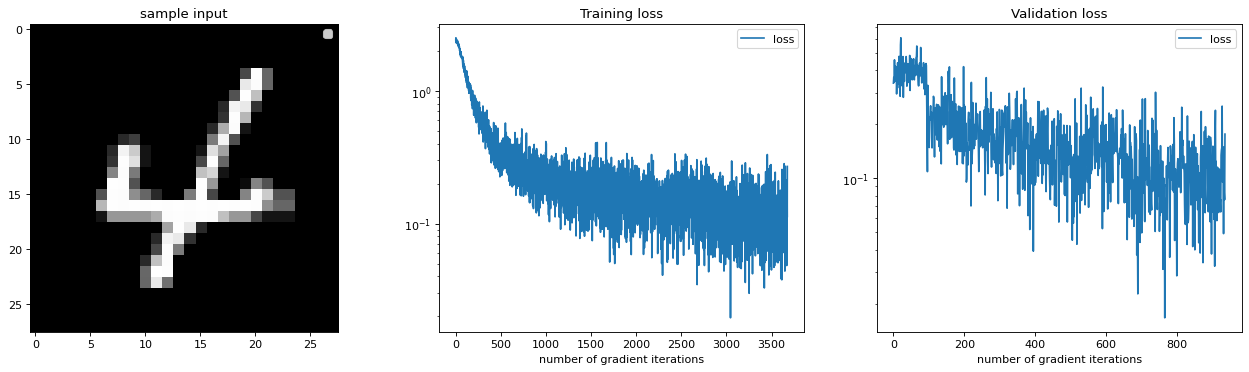

Validation epoch 9, iteration 90 of 94 (95 %), loss=0.1763


In [23]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss and backward the gradient
        loss = nn.CrossEntropyLoss()(pred['digit'], batch_gpu['digit'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()
            axes[1].cla()

            # plot some sample image inputs
            plot_images(batch_cpu['image'][0:1], ax=axes[0])
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))

    val_iter = iter(val_loader)
    network.eval()
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss
        with torch.no_grad():
            loss = nn.CrossEntropyLoss()(pred['digit'], batch_gpu['digit'])
            val_losses.append(loss.item())

        if i%10==0:
            axes[2].cla()

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))
plt.close('all')

### ToDo: Evaluation

#### Prediction Accuracy (1 pt)

The 'get_accuracy' function assumes that the network returns class probabilities as output. If your network returns class indices, you might need to change this evaluation function as well.

In [24]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)
    correct = 0
    total = 0
    for i in range(len(iterator)):
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)['digit'].argmax(dim=1, keepdim=True)
        correct += pred.eq(batch_gpu['digit'].view_as(pred)).sum().item()
        total += pred.shape[0]

    return correct / total

In [25]:
# ToDo: report accuracy on train, validation, and test sets
train_accuracy = get_accuracy(network, train_loader)
val_accuracy = get_accuracy(network, val_loader)
test_accuracy = get_accuracy(network, test_loader)

print(f"Accuracy on Train Set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Validation Set: {val_accuracy * 100:.2f}%")
print(f"Accuracy on Test Set: {test_accuracy * 100:.2f}%")

Accuracy on Train Set: 97.14%
Accuracy on Validation Set: 96.67%
Accuracy on Test Set: 96.54%


#### Qualitative Results (1 pt)

For a few samples in the test set (6 samples in the code below), plot the input images and their predicted digits.

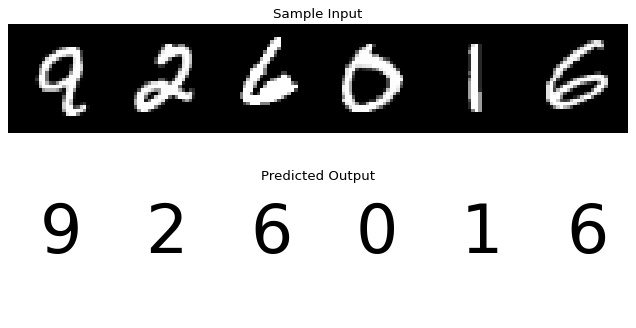

In [26]:
# ToDo: plot the input images and output of your network for a few samples in the test set


fig = plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(2,1)

test_iter = iter(test_loader)
network.eval()
for i in range(len(test_loader)):
    batch_cpu = next(test_iter)
    axes[0].set_title('Sample Input')
    axes[0].axis('off')
    plot_images(batch_cpu['image'][0:6], axes[0])
    batch_gpu = dict_to_device(batch_cpu, 'cuda')
    pred = network(batch_gpu)

    # ToDo: code here. get the digits from the predicted probabilities.
    axes[1].set_title('Predicted Output')
    axes[1].axis('off')
    predicted_digits = pred['digit'].argmax(dim=1).cpu().numpy()
    for idx, digit in enumerate(predicted_digits[0:6]):
        axes[1].text(0.17 * idx + 0.085, 0.5, str(digit), fontsize=60, ha='center', va='baseline')
    plt.subplots_adjust(hspace=0.3)

    break


## Q3 (5 pts)

### Dataset and Dataloader

In [27]:
# Use standard MNIST dataset
class MyDataset(torchvision.datasets.MNIST):
    def __init__(self, *args, debug=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.debug = debug

    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        img = data[0]
        digit = data[1]
        is_flipped = random.randint(0, 1)
        if is_flipped:
            img = torch.flip(img, [1])

        return {'image': img, 'digit': digit, 'is_flipped': is_flipped}

    def __len__(self):
        return super().__len__()

dataset = MyDataset(
    root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]),
    debug=True,
)

test_set = MyDataset(
    root = './',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ]),
    debug=True,
)

loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)

In [28]:
# Define the dataloaders and split into train, validation, and test

size = len(dataset)
train_set, val_set = torch.utils.data.random_split(dataset, [int(size * 0.8), int(size * 0.2)])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=0)

print('train_set:', len(train_set))
print('val_set:', len(val_set))
print('test_set:', len(test_set))

train_set: 48000
val_set: 12000
test_set: 10000


### ToDo: Network (3 pts)

Implement a **Multi-Task Vision Transformer** that takes an image as input and classifies it into ten classes, digits 0 to 9. Also, it predicts whether the image is upside down (vertically flipped) or not.

Your network should take a dictionary as input and extract the input image from it. Your network should return a dictionaly with keys 'digit' and 'is_flipped', indicating the digit of the image and whether it is vertically flipped.

In [29]:
# ToDo: Implement your network
import math

class MultiViT(nn.Module):
    def __init__(self):
        super(MultiViT, self).__init__()

        # ToDo: code here

        # Define attributes
        self.image_size = 28                          # Size of each raw image per side (28 x 28)
        self.patch_size = 7                           # Size of each patch image per side (7 x 7)
        self.patch_count = (self.image_size // self.patch_size) ** 2    # Number of patches per side (4 * 4 = 16)
        self.embedding_dim = 256                        # Dimension of embedding layer
        self.head_count = 8                           # Number of heads
        self.feedforward_dim = 256                       # Dimension of the feedforward network model
        self.encoder_layer_count = 1                      # Number of sub-encoder-layers in the encoder

        # Add the patch embedding layer
        self.patch_embedding_layer = patch_embedding(1, self.patch_size, self.embedding_dim)

        # Initialize the class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, self.embedding_dim))

        # Add positional encodings (+1 for the class token) and dropout layer
        self.pos_encodings = nn.Parameter(self.get_pos_encodings(self.embedding_dim, self.patch_count+1), requires_grad=False)
        self.dropout_layer = nn.Dropout(0.1)

        # Add the transformer encoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer = nn.TransformerEncoderLayer(
                d_model = self.embedding_dim,
                nhead = self.head_count,
                dim_feedforward = self.feedforward_dim,
                dropout = 0.1
            ),
            num_layers = self.encoder_layer_count
        )

        # 2 MLP heads for digit and flip prediction
        self.fc_digit_pred = nn.Linear(self.embedding_dim, 10)
        self.fc_flip_pred = nn.Linear(self.embedding_dim, 2)


    # Get positional encodings
    def get_pos_encodings(self, dimension, length):
        # Initialize a tensor of zeros for positional encodings with the specified length and dimension
        pos_enc = torch.zeros(length, dimension)

        # Generate a tensor of sequential positions and reshape it to (length, 1)
        # Calculate the division term used in the sin & cos functions
        position = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
        division_term = torch.exp(torch.arange(0, dimension, 2).float() * (-math.log(10000.0) / dimension))

        # Apply sin & cos functions to alternating positions
        # Sin function for even indices each row (0, 2, 4 ...)
        # Cos function for odd indices each row (1, 3, 5 ...)
        pos_enc[:, 0::2] = torch.sin(position * division_term)
        pos_enc[:, 1::2] = torch.cos(position * division_term)

        # Add an additional dimension at the beginning of the positional encoding tensor
        # Make it easier to add to the batch of embeddings later (1, length, dimension)
        pos_enc = pos_enc.unsqueeze(0)
        return pos_enc


        # - start with a patch_embedding layer to divide image into patches and
        #   convert each patch into vector embeddings
        # - append a class token to image tokens for digit prediction
        # - append another class token for predicting if the image is flipped
        # - add positional encodings
        # - using dropout might be helpful
        # - use a transformer encoder to calculate the attention weights
        # - apply an mlp head on the first class token to predict the digit
        # - apply an mlp head on the second class token to predict the inversion


    def forward(self, input_dict):
        x = input_dict['image']

        # ToDo: code here

        # Apply the patch embedding layer to the input image
        x = self.patch_embedding_layer(x)

        # Expand the class token for the entire batch (class token is a learnable parameter appended to the sequence of patch embeddings)
        class_tokens = self.class_token.expand(x.size(0), -1, -1)

        # Concatenate the class token with the patch embeddings (class token will be the first element)
        x = torch.cat((class_tokens, x), dim=1)

        # Add positional encodings to the patch embeddings (injects each patch's position information in the sequence)
        x = x + self.pos_encodings[:, :x.size(1)].repeat(x.size(0), 1, 1)

        # Pass the sequence through the transformer encoder
        x = self.encoder(x)

        # Aggregate the output of the transformer encoder (mean pooling for information across all patches)
        x = torch.mean(x, dim=1)

        # Pass to MLP head to produce the final classification predictions (digit & flip)
        digit_pred = self.fc_digit_pred(x)
        flip_pred = self.fc_flip_pred(x)

        return {'digit': digit_pred, 'is_flipped': flip_pred}


network = MultiViT().to('cuda')

In [30]:
total_params = sum(p.numel() for p in network.parameters())
print(f'The model has {total_params:,} parameters.')

The model has 416,268 parameters.


### Training

In [31]:
# feel free to implement your own loss function or use the suggested one here.

def my_loss_function(predicted_index, target_index):
  loss = nn.CrossEntropyLoss()(predicted_index, target_index)

  return loss

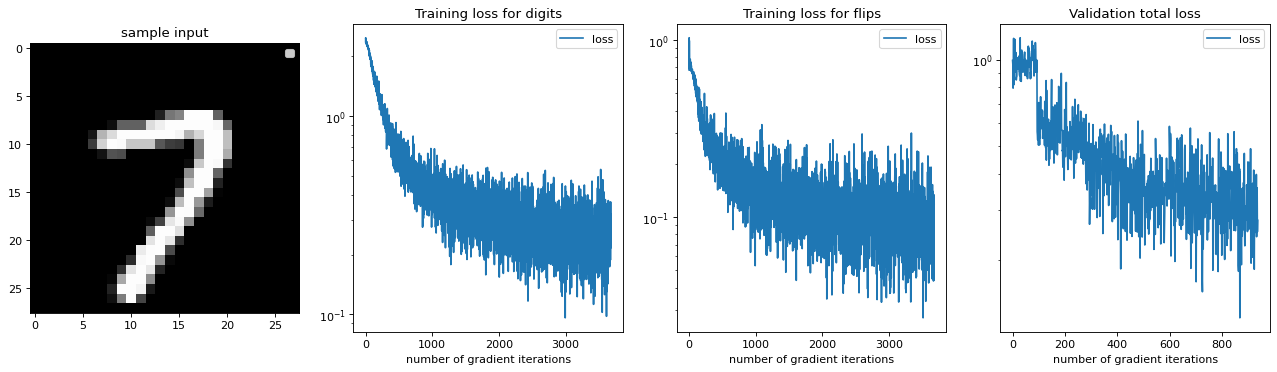

Validation epoch 9, iteration 90 of 94 (95 %), total_loss=0.2754


In [32]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,4)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 10
train_losses_digit = []
train_losses_flipped = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss and backward the gradient
        loss_digit = my_loss_function(pred['digit'], batch_gpu['digit'])
        loss_flipped = my_loss_function(pred['is_flipped'], batch_gpu['is_flipped'])
        loss = loss_digit + loss_flipped
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses_digit.append(loss_digit.item())
        train_losses_flipped.append(loss_flipped.item())

        if i%100==0:
            axes[0].cla()
            axes[1].cla()
            axes[2].cla()

            # plot some sample image inputs
            plot_images(batch_cpu['image'][0:1], ax=axes[0])
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot for loss_digit
            axes[1].plot(train_losses_digit, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss for digits')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # plot the training error on a log plot for loss_flipped
            axes[2].plot(train_losses_flipped, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Training loss for flips')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss_digit={:0.4f}, loss_flipped={:0.4f}".
                  format(e, i, len(train_loader), 100*i//len(train_loader), train_losses_digit[-1], train_losses_flipped[-1]))

    val_iter = iter(val_loader)
    network.eval()
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss
        with torch.no_grad():
            loss_digit = my_loss_function(pred['digit'], batch_gpu['digit'])
            loss_flipped = my_loss_function(pred['is_flipped'], batch_gpu['is_flipped'])
            loss = loss_digit + loss_flipped
            val_losses.append(loss.item())

        if i%10==0:
            axes[3].cla()

            # plot the validation error on a log plot
            axes[3].plot(val_losses, label='loss')
            axes[3].set_yscale('log')
            axes[3].set_title('Validation total loss')
            axes[3].set_xlabel('number of gradient iterations')
            axes[3].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), total_loss={:0.4f}".
                  format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))
plt.close('all')

### ToDo: Evaluation

#### Prediction Accuracy (1 pt)

The 'get_accuracy' function assumes that the network returns class probabilities as output. If your network returns class indices, you might need to change this evaluation function as well.

In [33]:
def get_accuracy(network, data_loader, label='digit'): # label = 'digit' or 'is_flipped'
    network.eval()
    iterator = iter(data_loader)
    correct = 0
    total = 0
    for i in range(len(iterator)):
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)[label].argmax(dim=1, keepdim=True)
        correct += pred.eq(batch_gpu[label].view_as(pred)).sum().item()
        total += pred.shape[0]

    return correct / total

In [34]:
# ToDo: report accuracy for digit prediction
print('Digit prediction')
train_accuracy = get_accuracy(network, train_loader)
val_accuracy = get_accuracy(network, val_loader)
test_accuracy = get_accuracy(network, test_loader)

print(f"Accuracy on Train Set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Validation Set: {val_accuracy * 100:.2f}%")
print(f"Accuracy on Test Set: {test_accuracy * 100:.2f}%")

Digit prediction
Accuracy on Train Set: 93.87%
Accuracy on Validation Set: 92.82%
Accuracy on Test Set: 93.27%


In [35]:
# ToDo: report accuracy for inversion prediction
print('Inversion prediction')
train_accuracy = get_accuracy(network, train_loader, 'is_flipped')
val_accuracy = get_accuracy(network, val_loader, 'is_flipped')
test_accuracy = get_accuracy(network, test_loader, 'is_flipped')

print(f"Accuracy on Train Set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Validation Set: {val_accuracy * 100:.2f}%")
print(f"Accuracy on Test Set: {test_accuracy * 100:.2f}%")

Inversion prediction
Accuracy on Train Set: 97.16%
Accuracy on Validation Set: 97.15%
Accuracy on Test Set: 96.87%


#### Qualitative Results (1 pt)

For a few samples in the test set (6 samples in the code below), plot the input images and their predicted digits.

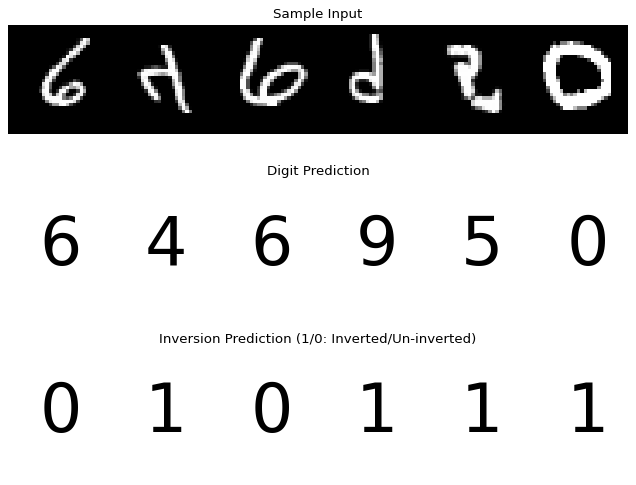

In [36]:
# ToDo: plot the input images and output of your network for a few samples in the test set

fig = plt.figure(figsize=(10, 7.5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(3,1)

test_iter = iter(test_loader)
network.eval()
for i in range(len(test_loader)):
    batch_cpu = next(test_iter)
    axes[0].set_title('Sample Input')
    axes[0].axis('off')
    plot_images(batch_cpu['image'][0:6], ax=axes[0])
    batch_gpu = dict_to_device(batch_cpu, 'cuda')
    pred = network(batch_gpu)

    # ToDo: code here. get the digits from the predicted probabilities.

    # Get the digits from digit prediction
    axes[1].set_title('Digit Prediction')
    axes[1].axis('off')
    predicted_digits = pred['digit'].argmax(dim=1).cpu().numpy()
    for idx, digit in enumerate(predicted_digits[0:6]):
        axes[1].text(0.17 * idx + 0.085, 0.5, str(digit), fontsize=60, ha='center', va='center')
    plt.subplots_adjust(hspace=0.3)

    # Get the results from inversion prediction
    axes[2].set_title('Inversion Prediction (1/0: Inverted/Un-inverted)')
    axes[2].axis('off')
    predicted_flips = pred['is_flipped'].argmax(dim=1).cpu().numpy()
    for idx, result in enumerate(predicted_flips[0:6]):
        axes[2].text(0.17 * idx + 0.085, 0.5, str(result), fontsize=60, ha='center', va='center')
    plt.subplots_adjust(hspace=0.3)

    break
